In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'imdb-dataset-of-top-1000-movies-and-tv-shows:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1131493%2F1898721%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240606%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240606T114541Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Daeb6ce45d679a942b5b7dbeae471aa634ddc7a6fa9be5ef77ae0e32795d84ab0ce4c43d88f81c0779fdc87232141fba696e522ad8e3ff95e16b8b996fa11c9d413278ffa146a53f551a84d35d21464623a3cde84b012ab029830fb0b8fc2dcc18ce01971badf54be9e9c13d4f648353c6a349c69b7468d34c81e450f6cbeb04108d8524eb5a7439305e2e53d4ca02dfcfe6edf462de841b2daa4af3a7bb226ca89731fcbdc82019dd0a097cb6edbfbb5823833680dbc6e05c3fe1d41f23636f3b0e61204c579417ed2eae5c32256fbfd4dd4cba64627c70da82c69d2c06c5392fa3b51fa2ea62ef6358eb9fa1a248af5f07dc168c5be4a6fd73f5af42fd6a98c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re

In [ ]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-top-1000-movies-and-tv-shows/imdb_top_1000.csv')

In [ ]:
df.isna().sum()

Poster_Link        0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

In [ ]:
df = df.dropna()
df.isna().sum()

In [ ]:
df.dtypes

Poster_Link       object
Series_Title      object
Released_Year     object
Certificate       object
Runtime           object
Genre             object
IMDB_Rating      float64
Overview          object
Meta_score       float64
Director          object
Star1             object
Star2             object
Star3             object
Star4             object
No_of_Votes        int64
Gross             object
dtype: object

In [ ]:
df['Gross']=df['Gross'].str.replace(',', '')
df['Gross']=df['Gross'].astype(int)

In [ ]:
def estrai_durata(text):
    return re.sub(r'(\d+)\smin', r'\1', text)
df['Runtime']=df['Runtime'].apply(estrai_durata)
df['Runtime']= df['Runtime'].astype(int)

In [ ]:
df.columns

Index(['Poster_Link', 'Series_Title', 'Certificate', 'Runtime', 'Genre',
       'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1', 'Star2',
       'Star3', 'Star4', 'No_of_Votes', 'Gross'],
      dtype='object')

In [ ]:
df[df['Released_Year'] == "PG"]

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
966,https://m.media-amazon.com/images/M/MV5BNjEzYj...,Apollo 13,PG,U,140 min,"Adventure, Drama, History",7.6,NASA must devise a strategy to return Apollo 1...,77.0,Ron Howard,Tom Hanks,Bill Paxton,Kevin Bacon,Gary Sinise,269197,173837933


In [ ]:
df['Released_Year']=df['Released_Year'].replace("PG","1995")

In [ ]:
df['Released_Year']= df['Released_Year'].astype(int)

In [ ]:
df.dtypes

Poster_Link      object
Series_Title     object
Certificate      object
Runtime           int64
Genre            object
IMDB_Rating     float64
Overview         object
Meta_score      float64
Director         object
Star1            object
Star2            object
Star3            object
Star4            object
No_of_Votes       int64
Gross             int64
dtype: object

In [ ]:
df.set_index('Released_Year',inplace = True)

In [ ]:
df.head(3)

,Poster_Link,Series_Title,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
Released_Year,,,,,,,,,,,,,,,
1994,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,A,142,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469
1972,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411
2008,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


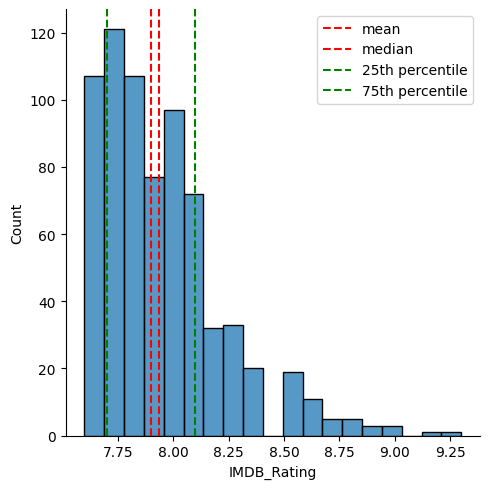

In [ ]:
sns.displot(df['IMDB_Rating'])
plt.axvline(x=np.mean(df['IMDB_Rating']), c = 'red', ls = '--', label = 'mean')
plt.axvline(x=np.median(df['IMDB_Rating']), c = 'red', ls = '--', label = 'median')
plt.axvline(x=np.percentile(df['IMDB_Rating'],25), c = 'green', ls = '--', label = '25th percentile')
plt.axvline(x=np.percentile(df['IMDB_Rating'],75), c = 'green', ls = '--', label = '75th percentile')
plt.legend()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


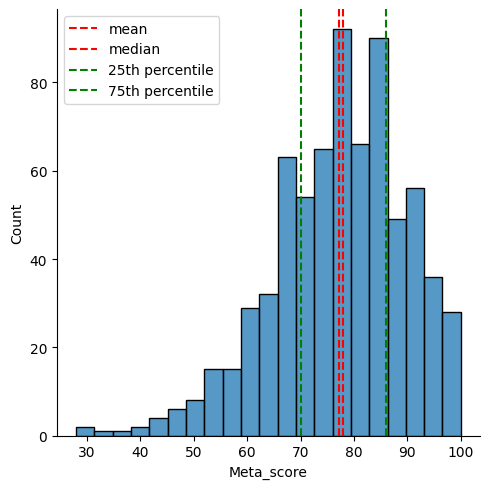

In [ ]:
sns.displot(df['Meta_score'])
plt.axvline(x=np.mean(df['Meta_score']), c = 'red', ls = '--', label = 'mean')
plt.axvline(x=np.median(df['Meta_score']), c = 'red', ls = '--', label = 'median')
plt.axvline(x=np.percentile(df['Meta_score'],25), c = 'green', ls = '--', label = '25th percentile')
plt.axvline(x=np.percentile(df['Meta_score'],75), c = 'green', ls = '--', label = '75th percentile')
plt.legend()

In [ ]:
df['Genre'] = df['Genre'].apply(lambda x: x.split(', '))
df_count = df.explode('Genre')
df_count.head()

,Poster_Link,Series_Title,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
Released_Year,,,,,,,,,,,,,,,
1994,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469
1972,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,A,175 min,Crime,9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411
1972,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,A,175 min,Drama,9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411
2008,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,UA,152 min,Action,9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444
2008,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,UA,152 min,Crime,9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,https://m.media-amazon.com/images/M/MV5BZjQyMG...,A Hard Day's Night,U,87 min,Music,7.6,"Over two ""typical"" days in the life of The Bea...",96.0,Richard Lester,John Lennon,Paul McCartney,George Harrison,Ringo Starr,40351,13780024
1964,https://m.media-amazon.com/images/M/MV5BZjQyMG...,A Hard Day's Night,U,87 min,Musical,7.6,"Over two ""typical"" days in the life of The Bea...",96.0,Richard Lester,John Lennon,Paul McCartney,George Harrison,Ringo Starr,40351,13780024
1953,https://m.media-amazon.com/images/M/MV5BM2U3Yz...,From Here to Eternity,Passed,118 min,Drama,7.6,"In Hawaii in 1941, a private is cruelly punish...",85.0,Fred Zinnemann,Burt Lancaster,Montgomery Clift,Deborah Kerr,Donna Reed,43374,30500000


In [ ]:
df_count['Genre'].value_counts()

Genre
Drama        500
Adventure    163
Comedy       161
Crime        142
Action       140
Thriller      99
Biography     88
Romance       88
Mystery       70
Animation     63
Sci-Fi        56
Fantasy       55
Family        43
History       38
War           29
Music         27
Horror        18
Sport         17
Western       16
Musical       11
Film-Noir      6
Name: count, dtype: int64

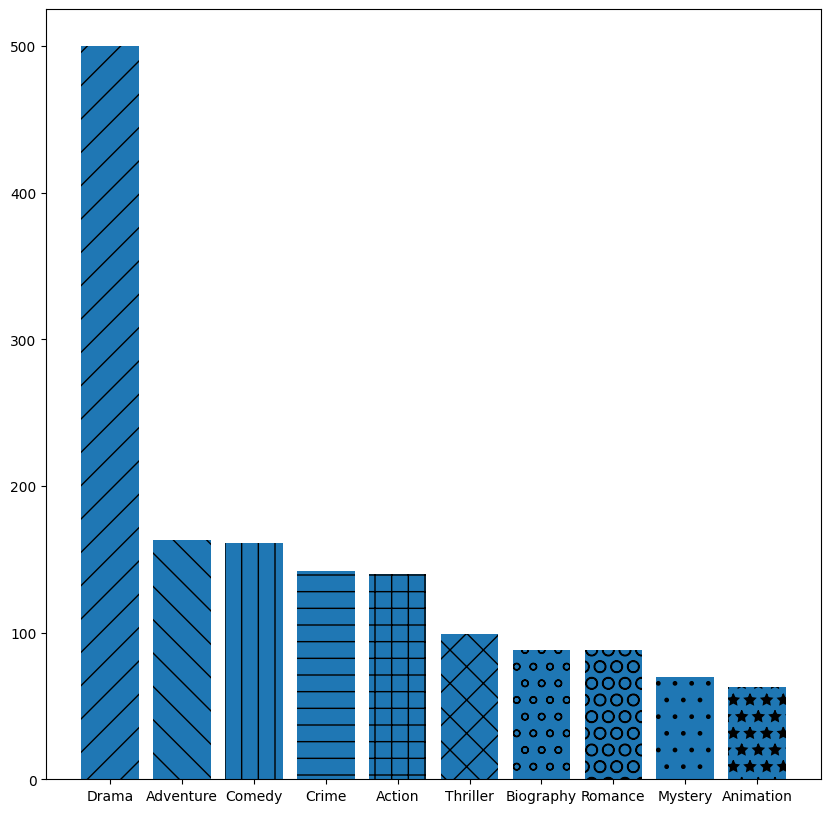

In [ ]:
plt.figure(figsize=(10, 10))
bars = plt.bar(df_count['Genre'].value_counts().head(10).index,df_count['Genre'].value_counts().head(10).values)
patterns = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
for bar, pattern in zip(bars, patterns):
    bar.set_hatch(pattern)

In [ ]:
df.index

Index([1994, 1972, 2008, 1974, 1957, 2003, 1994, 1993, 2010, 1999,
       ...
       1979, 1979, 1978, 1977, 1973, 1971, 1970, 1967, 1964, 1953],
      dtype='int64', name='Released_Year', length=714)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


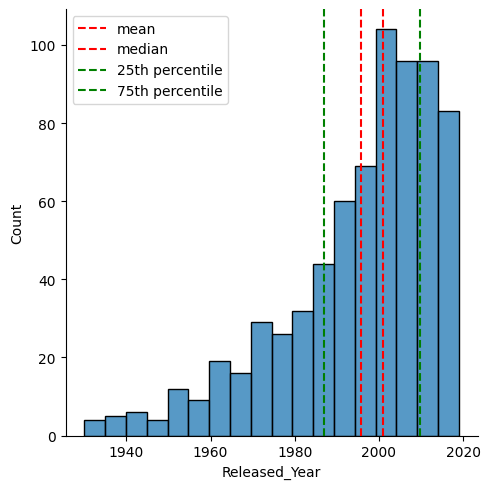

In [ ]:
sns.displot(df.index)
plt.axvline(x=np.mean(df.index), c = 'red', ls = '--', label = 'mean')
plt.axvline(x=np.median(df.index), c = 'red', ls = '--', label = 'median')
plt.axvline(x=np.percentile(df.index,25), c = 'green', ls = '--', label = '25th percentile')
plt.axvline(x=np.percentile(df.index,75), c = 'green', ls = '--', label = '75th percentile')
plt.legend()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


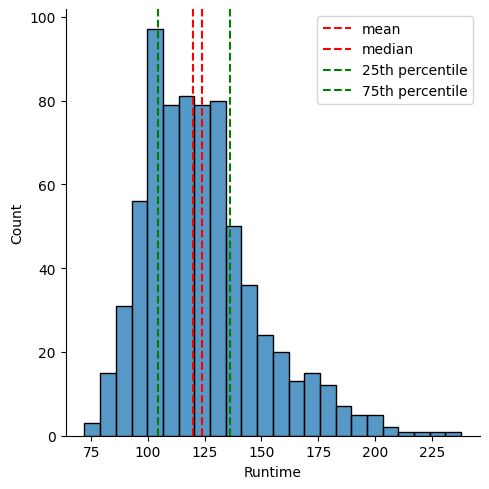

In [ ]:
sns.displot(df['Runtime'])
plt.axvline(x=np.mean(df['Runtime']), c = 'red', ls = '--', label = 'mean')
plt.axvline(x=np.median(df['Runtime']), c = 'red', ls = '--', label = 'median')
plt.axvline(x=np.percentile(df['Runtime'],25), c = 'green', ls = '--', label = '25th percentile')
plt.axvline(x=np.percentile(df['Runtime'],75), c = 'green', ls = '--', label = '75th percentile')
plt.legend()

In [ ]:
df['Director'].value_counts().head(10)

Director
Steven Spielberg     13
Martin Scorsese      10
Alfred Hitchcock      9
Christopher Nolan     8
Clint Eastwood        8
Quentin Tarantino     8
David Fincher         8
Hayao Miyazaki        7
Rob Reiner            7
Woody Allen           7
Name: count, dtype: int64

<Axes: xlabel='Director', ylabel='IMDB_Rating'>

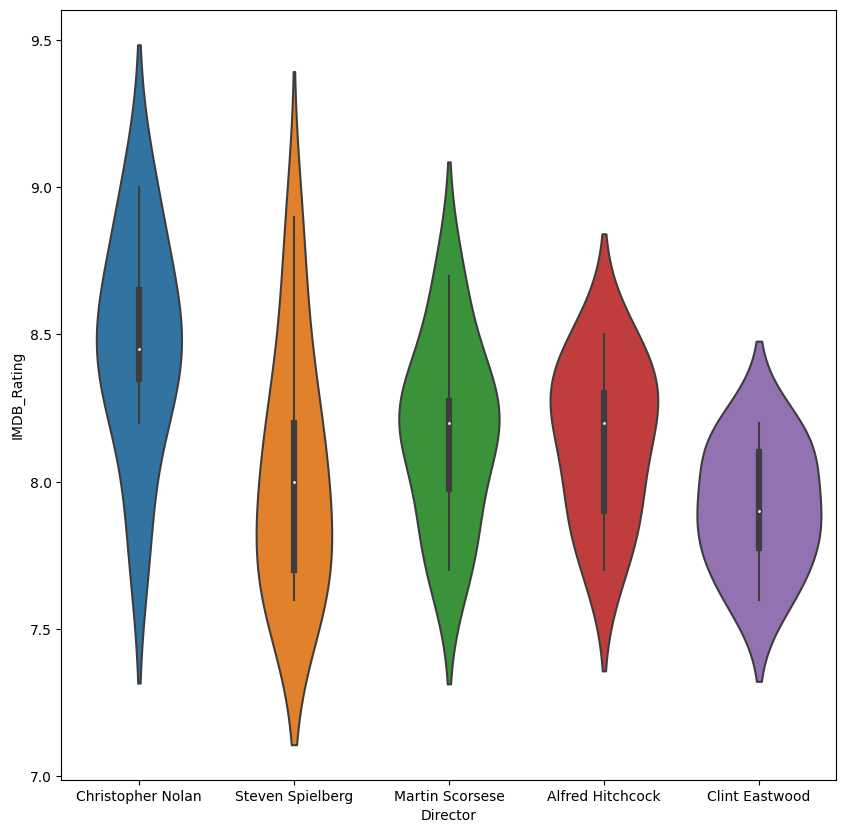

In [ ]:
top_directors = df['Director'].value_counts().head(5).index
filtered_df = df[df['Director'].isin(top_directors)]
plt.figure(figsize=(10, 10))
sns.violinplot(x='Director', y='IMDB_Rating', data=filtered_df)


<Axes: xlabel='Director', ylabel='Meta_score'>

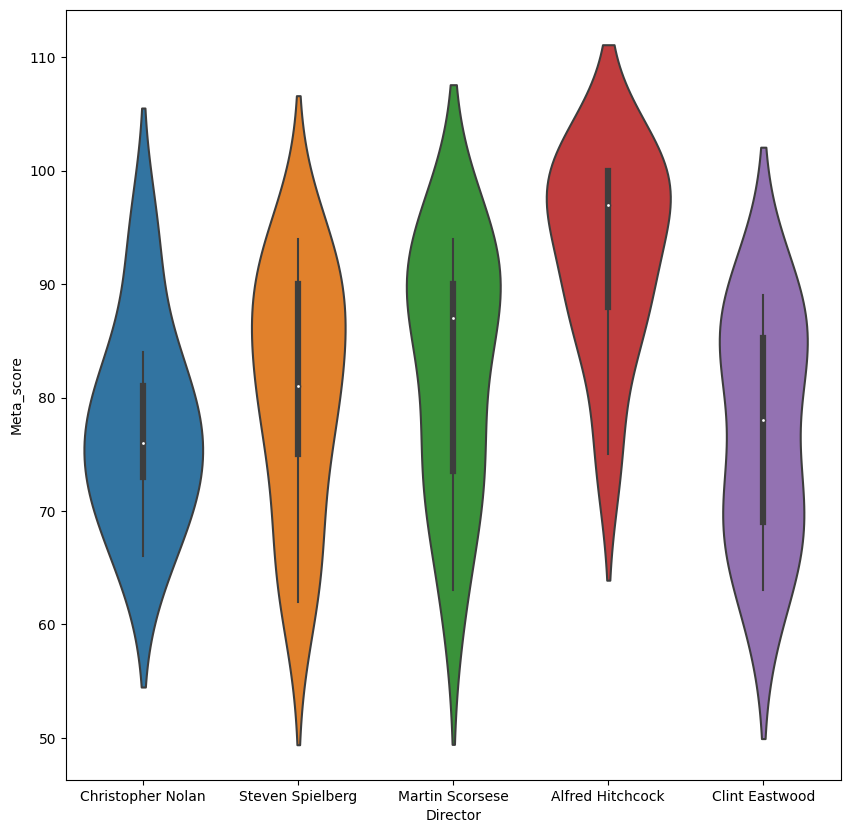

In [ ]:
plt.figure(figsize=(10, 10))

sns.violinplot(x='Director', y='Meta_score', data=filtered_df)

,Poster_Link,Series_Title,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
Released_Year,,,,,,,,,,,,,,,
1994,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,A,142,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469
1972,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,A,175,Crime,9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411
1972,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,A,175,Drama,9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411
2008,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,UA,152,Action,9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444
2008,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,UA,152,Crime,9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,https://m.media-amazon.com/images/M/MV5BMzAyND...,Kelly's Heroes,GP,144,Adventure,7.6,A group of U.S. soldiers sneaks across enemy l...,50.0,Brian G. Hutton,Clint Eastwood,Telly Savalas,Don Rickles,Carroll O'Connor,45338,1378435
1970,https://m.media-amazon.com/images/M/MV5BMzAyND...,Kelly's Heroes,GP,144,Comedy,7.6,A group of U.S. soldiers sneaks across enemy l...,50.0,Brian G. Hutton,Clint Eastwood,Telly Savalas,Don Rickles,Carroll O'Connor,45338,1378435
1967,https://m.media-amazon.com/images/M/MV5BMjAwMT...,The Jungle Book,U,78,Adventure,7.6,Bagheera the Panther and Baloo the Bear have a...,65.0,Wolfgang Reitherman,Phil Harris,Sebastian Cabot,Louis Prima,Bruce Reitherman,166409,141843612


In [ ]:
top_genre = df_count['Genre'].value_counts().head(5).index
df_count['Runtime']=df_count['Runtime'].apply(estrai_durata)
df_count['Runtime']= df_count['Runtime'].astype(int)

In [ ]:
df_count.dtypes

Poster_Link      object
Series_Title     object
Certificate      object
Runtime           int64
Genre            object
IMDB_Rating     float64
Overview         object
Meta_score      float64
Director         object
Star1            object
Star2            object
Star3            object
Star4            object
No_of_Votes       int64
Gross             int64
dtype: object

<Axes: xlabel='Genre', ylabel='Runtime'>

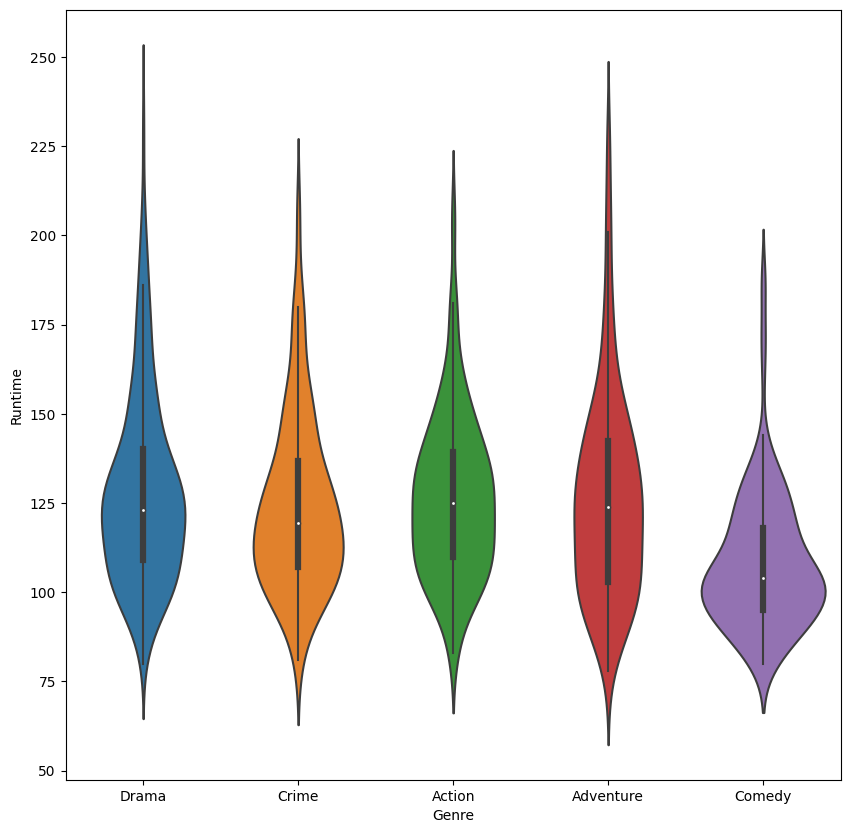

In [ ]:
filtered_df= df_count[df_count['Genre'].isin(top_genre)]
plt.figure(figsize=(10, 10))
sns.violinplot(x='Genre', y='Runtime', data=filtered_df)

<Axes: xlabel='Released_Year', ylabel='IMDB_Rating'>

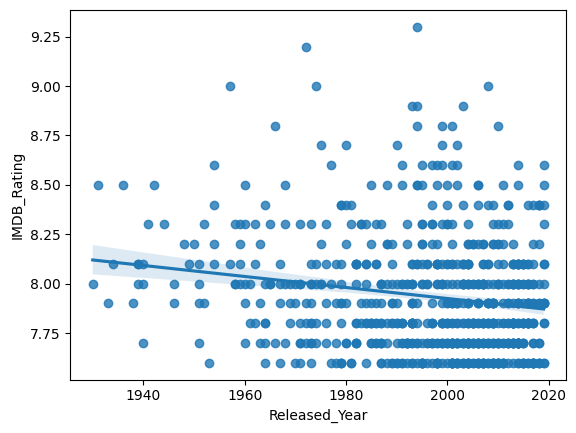

In [ ]:
sns.regplot( x=df.index, y=df['IMDB_Rating'])

<Axes: xlabel='Released_Year', ylabel='Meta_score'>

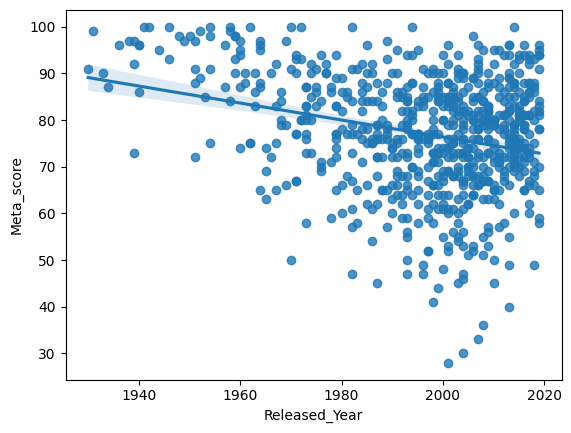

In [ ]:
sns.regplot( x=df.index, y=df['Meta_score'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


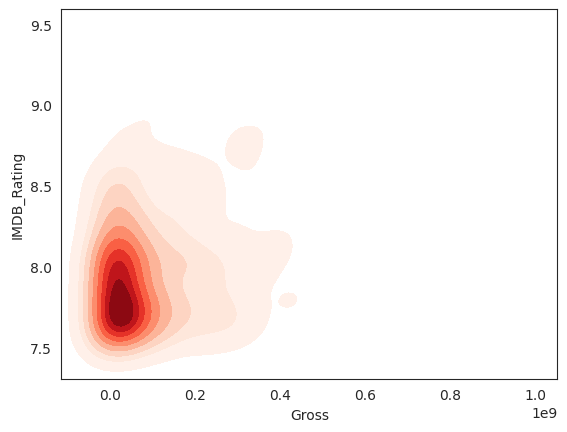

In [ ]:
sns.set_style("white")
sns.kdeplot(x=df["Gross"], y=df["IMDB_Rating"],cmap="Reds", fill=True)
plt.show()


In [ ]:
all_stars =pd.concat([df['Star1'], df['Star2'], df['Star3'], df['Star4']])
top_20_actors= all_stars.value_counts().head(20)

In [ ]:
Star1= df.groupby('Star1')['IMDB_Rating'].mean().sort_values(ascending=False)
filter_star1= Star1[Star1.index.isin(top_20_actors)]

In [ ]:
Star2= df.groupby('Star2')['IMDB_Rating'].mean().sort_values(ascending=False)
filter_star2= Star2[Star2.index.isin(top_20_actors)]

In [ ]:
Star3= df.groupby('Star3')['IMDB_Rating'].mean().sort_values(ascending=False)
filter_star3= Star3[Star3.index.isin(top_20_actors)]

In [ ]:
Star4= df.groupby('Star4')['IMDB_Rating'].mean().sort_values(ascending=False)
filter_star4= Star4[Star4.index.isin(top_20_actors)]

In [ ]:
all_actors = filter_star1.index.union(filter_star2.index).union(filter_star3.index).union(filter_star4.index)
unique_actors = pd.Index(all_actors).unique()
df_actors = pd.DataFrame(unique_actors, columns=['Star'])
df_actors

,Star
0,Al Pacino
1,Brad Pitt
2,Bruce Willis
3,Christian Bale
4,Clint Eastwood
5,Denzel Washington
6,Edward Norton
7,Emma Watson
8,Ethan Hawke
9,Harrison Ford


In [ ]:
df_actors['Average_Rating'] = 0.0

for idx, row in df_actors.iterrows():
    actor = row['Star']
    ratings = []

    if actor in filter_star1.index:
        ratings.append(filter_star1[actor])
    if actor in filter_star2.index:
        ratings.append(filter_star2[actor])
    if actor in filter_star3.index:
        ratings.append(filter_star3[actor])
    if actor in filter_star4.index:
        ratings.append(filter_star4[actor])

    if ratings:
        average_rating = sum(ratings) / len(ratings)
    else:
        average_rating = 0

    df_actors.at[idx, 'Average_Rating'] = average_rating
df_actors.sort_values(by='Average_Rating', ascending=False)

,Star,Average_Rating
9,Harrison Ford,8.316667
15,Morgan Freeman,8.300000
2,Bruce Willis,8.206667
6,Edward Norton,8.155556
0,Al Pacino,8.155000
10,Ian McKellen,8.150000
16,Robert De Niro,8.146667
13,Leonardo DiCaprio,8.111111
4,Clint Eastwood,8.035000
17,Russell Crowe,8.020000


In [ ]:
df_actors

,Star,Average_Rating
0,Al Pacino,8.155000
1,Brad Pitt,7.981250
2,Bruce Willis,8.206667
3,Christian Bale,7.989583
4,Clint Eastwood,8.035000
5,Denzel Washington,7.725000
6,Edward Norton,8.155556
7,Emma Watson,7.828571
8,Ethan Hawke,7.863333
9,Harrison Ford,8.316667


In [ ]:
all_stars.value_counts().head(20)

Robert De Niro        16
Tom Hanks             14
Al Pacino             13
Brad Pitt             12
Christian Bale        11
Matt Damon            11
Clint Eastwood        11
Leonardo DiCaprio     11
Scarlett Johansson     9
Denzel Washington      9
Johnny Depp            9
Ethan Hawke            9
Harrison Ford          8
Morgan Freeman         7
Ian McKellen           7
Bruce Willis           7
Edward Norton          7
Russell Crowe          7
Emma Watson            7
Jeff Bridges           7
Name: count, dtype: int64

In [ ]:
corr = np.round(df.select_dtypes(include=[np.number]).corr(),2)


<Axes: >

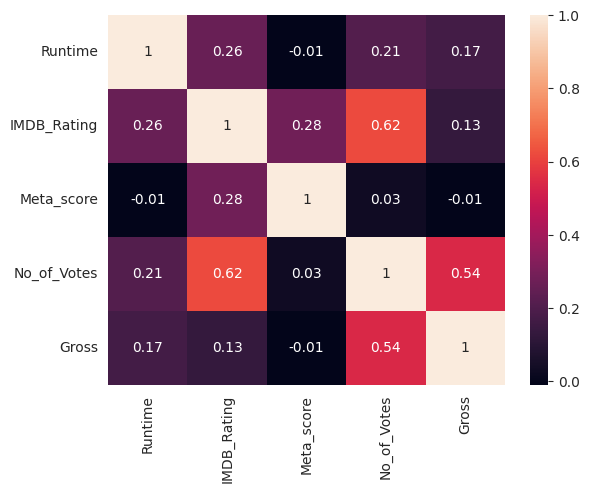

In [ ]:
sns.heatmap(corr, annot = True)

<Axes: xlabel='No_of_Votes', ylabel='Meta_score'>

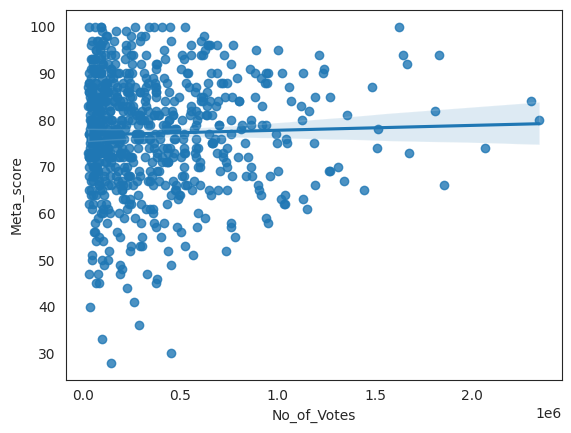